In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import time
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve


def load_data():
    train_base_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/train_baseline.parquet/')) if x.endswith('.parquet')][0]
    test_base_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/test_baseline.parquet/')) if x.endswith('.parquet')][0]
    train_rvrs_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/train_rvrs.parquet/')) if x.endswith('.parquet')][0]
    test_rvrs_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/test_rvrs.parquet/')) if x.endswith('.parquet')][0]

    # load as dataframes
    train_baseline_df = pd.read_parquet(os.path.join(ROOT,'data/train_baseline.parquet/', train_base_parquet_file))
    test_baseline_df = pd.read_parquet(os.path.join(ROOT,'data/test_baseline.parquet/', test_base_parquet_file))
    train_malicious_df = pd.read_parquet(os.path.join(ROOT,'data/train_rvrs.parquet/', train_rvrs_parquet_file))
    test_malicious_df = pd.read_parquet(os.path.join(ROOT,'data/test_rvrs.parquet/', test_rvrs_parquet_file))

    X_train_non_shuffled = train_baseline_df['cmd'].values.tolist() + train_malicious_df['cmd'].values.tolist()
    y_train = np.array([0] * len(train_baseline_df) + [1] * len(train_malicious_df), dtype=np.int8)
    X_train_cmds, y_train = shuffle(X_train_non_shuffled, y_train, random_state=SEED)

    X_test_non_shuffled = test_baseline_df['cmd'].values.tolist() + test_malicious_df['cmd'].values.tolist()
    y_test = np.array([0] * len(test_baseline_df) + [1] * len(test_malicious_df), dtype=np.int8)
    X_test_cmds, y_test = shuffle(X_test_non_shuffled, y_test, random_state=SEED)

    # ===========================================
    # DATASET LIMITS FOR TESTING
    # ===========================================
    X_train_cmds = X_train_cmds[:LIMIT]
    y_train = y_train[:LIMIT]
    
    X_test_cmds = X_test_cmds[:LIMIT]
    y_test = y_test[:LIMIT]

    return X_train_cmds, y_train, X_test_cmds, y_test

SEED = 33

VOCAB_SIZE = 4096
EMBEDDED_DIM = 64
MAX_LEN = 128
BATCH_SIZE = 1024
DROPOUT = 0.5
LIMIT = None
DATALOADER_WORKERS = 4


# ===========================================
# LOADING DATA
# ===========================================

ROOT = os.path.dirname(os.path.abspath("__file__"))
X_train_cmds, y_train, X_test_cmds, y_test = load_data()
print(f"Sizes of train and test sets: {len(X_train_cmds)}, {len(X_test_cmds)}")

LOGS_FOLDER = "logs_models"
y_preds_pickle = os.path.join(LOGS_FOLDER, "y_preds.pickle")
if os.path.exists(y_preds_pickle):
    print("[*] Loading predictions...")
    with open(y_preds_pickle, "rb") as f:
        y_preds = pickle.load(f)
else:
    y_preds = {}

    from watermark import watermark

    print(watermark(packages="torch,lightning,sklearn", python=True))
    print(f"[!] Script start time: {time.ctime()}")

    # encoders
    from sklearn.feature_extraction.text import HashingVectorizer

    # tokenizers
    from nltk.tokenize import wordpunct_tokenize, WhitespaceTokenizer
    whitespace_tokenize = WhitespaceTokenizer().tokenize

    # modeling
    import lightning as L
    from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
    from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
    from lightning.lite.utilities.seed import seed_everything

    # import random forest, xgboost, and logistic regression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier

    from src.models import *
    from src.lit_utils import LitProgressBar
    from src.preprocessors import CommandTokenizer, OneHotCustomVectorizer
    from src.data_utils import create_dataloader

    from typing import List
    from torch.utils.data import DataLoader

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def get_tpr_at_fpr(predicted_logits, true_labels, fprNeeded=1e-4):
        if isinstance(predicted_logits, torch.Tensor):
            predicted_probs = torch.sigmoid(predicted_logits).cpu().detach().numpy()
        else:
            predicted_probs = sigmoid(predicted_logits)
        
        if isinstance(true_labels, torch.Tensor):
            true_labels = true_labels.cpu().detach().numpy()
        
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
        if all(np.isnan(fpr)):
            return np.nan#, np.nan
        else:
            tpr_at_fpr = tpr[fpr <= fprNeeded][-1]
            #threshold_at_fpr = thresholds[fpr <= fprNeeded][-1]
            return tpr_at_fpr#, threshold_at_fpr


    def commands_to_loader(cmd: List[str], tokenizer: CommandTokenizer, y: np.ndarray = None) -> DataLoader:
        """Convert a list of commands to a DataLoader."""
        tokens = tokenizer.tokenize(cmd)
        ints = tokenizer.encode(tokens)
        padded = tokenizer.pad(ints, MAX_LEN)
        if y is None:
            loader = create_dataloader(padded, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
        else:
            loader = create_dataloader(padded, y, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
        return loader


    def configure_trainer():
        """Configure the PyTorch Lightning Trainer."""

        trainer = L.Trainer(
            num_sanity_val_steps=0,
            max_epochs=1,
            accelerator="gpu",
            devices=1,
            callbacks=[LitProgressBar()],
            logger=TensorBoardLogger("logs_temp_results_roc_ablation_models", name="my_model"),
            val_check_interval=0.5,
            log_every_n_steps=10,
        )
        return trainer


    def load_lit_model(model_file, pytorch_model, name, log_folder):
        lightning_model = PyTorchLightningModel.load_from_checkpoint(checkpoint_path=model_file, model=pytorch_model)
        trainer = configure_trainer()
        return trainer, lightning_model

    seed_everything(SEED)
    TOKENIZER = wordpunct_tokenize

    # =============================================
    # PREPING DATA
    # =============================================
    tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE)

    # ========== EMBEDDING ==========
    vocab_file = os.path.join(LOGS_FOLDER, f"wordpunct_vocab_{VOCAB_SIZE}.json")
    if os.path.exists(vocab_file):
        print("[*] Loading vocab...")
        tokenizer.load_vocab(vocab_file)
    else:
        print("[*] Building vocab and encoding...")
        X_train_tokens = tokenizer.tokenize(X_train_cmds)
        tokenizer.build_vocab(X_train_tokens)
        tokenizer.dump_vocab(vocab_file)

    # creating dataloaders
    # X_train_loader = commands_to_loader(X_train_cmds, tokenizer, y_train)
    X_test_loader = commands_to_loader(X_test_cmds, tokenizer, y_test)

    # ========== MIN-HASH TABULAR ENCODING ==========
    minhash_vectorizer_file = os.path.join(LOGS_FOLDER, f"minhash_vectorizer_{VOCAB_SIZE}.pkl")
    if os.path.exists(minhash_vectorizer_file):
        print("[*] Loading MinHash vectorizer...")
        minhash = pickle.load(open(minhash_vectorizer_file, "rb"))
    else:
        minhash = HashingVectorizer(n_features=VOCAB_SIZE, tokenizer=TOKENIZER, token_pattern=None)
        print("[*] Fitting MinHash encoder...")
        minhash.fit(X_train_cmds)
        
        with open(minhash_vectorizer_file, "wb") as f:
            pickle.dump(minhash, f)

    # X_train_minhash = minhash.transform(X_train_cmds)
    X_test_minhash = minhash.transform(X_test_cmds)

    # ========== ONE-HOT TABULAR ENCODING ===========
    oh_vectorizer_file = os.path.join(LOGS_FOLDER, f"onehot_vectorizer_{VOCAB_SIZE}.pkl")
    if os.path.exists(oh_vectorizer_file):
        print("[*] Loading One-Hot vectorizer...")
        oh = pickle.load(open(oh_vectorizer_file, "rb"))
    else:
        oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
        print("[*] Fitting One-Hot encoder...")
        oh.fit(X_train_cmds)

        with open(oh_vectorizer_file, "wb") as f:
            pickle.dump(oh, f)

    # X_train_onehot = oh.transform(X_train_cmds)
    X_test_onehot = oh.transform(X_test_cmds)

    # =============================================
    # DEFINING MODELS
    # =============================================
    print(f"[*] Defining models...")

    # sequence models
    mlp_seq_model = SimpleMLPWithEmbedding(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDED_DIM, output_dim=1, hidden_dim=[256, 64, 32], use_positional_encoding=False, max_len=MAX_LEN, dropout=DROPOUT) # 297 K params
    cnn_model = CNN1DGroupedModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, num_channels=32, kernel_sizes=[2, 3, 4, 5], mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 301 K params
    lstm_model = BiLSTMModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, hidden_dim=32, mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 318 K params
    cnn_lstm_model = CNN1D_BiLSTM_Model(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, num_channels=32, kernel_size=3, lstm_hidden_dim=32, mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 316 K params
    mean_transformer_model = MeanTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) # 335 K params
    cls_transformer_model = CLSTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) #  335 K params
    attpool_transformer_model = AttentionPoolingTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) #  335 K params
    neurlux = NeurLuxModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, max_len=MAX_LEN, hidden_dim=32, output_dim=1, dropout=DROPOUT) # 402 K params

    # tabular models
    rf_model_minhash = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
    xgb_model_minhash = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)
    log_reg_minhash = LogisticRegression(random_state=SEED)
    mlp_tab_model_minhash = SimpleMLP(input_dim=VOCAB_SIZE, output_dim=1, hidden_dim=[64, 32], dropout=DROPOUT) # 264 K params
    rf_model_onehot = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
    xgb_model_onehot = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)
    log_reg_onehot = LogisticRegression(random_state=SEED)
    mlp_tab_model_onehot = SimpleMLP(input_dim=VOCAB_SIZE, output_dim=1, hidden_dim=[64, 32], dropout=DROPOUT) # 264 K params

    models = {
        "_tabular_mlp_minhash": mlp_tab_model_minhash,
        "_tabular_rf_minhash": rf_model_minhash,
        "_tabular_xgb_minhash": xgb_model_minhash,
        "_tabular_log_reg_minhash": log_reg_minhash,
        "_tabular_mlp_onehot": mlp_tab_model_onehot,
        "_tabular_rf_onehot": rf_model_onehot,
        "_tabular_xgb_onehot": xgb_model_onehot,
        "_tabular_log_reg_onehot": log_reg_onehot,
        "mlp_seq": mlp_seq_model,
        "attpool_transformer": attpool_transformer_model,
        "cls_transformer": cls_transformer_model,
        "mean_transformer": mean_transformer_model,
        "neurlux": neurlux,
        "cnn": cnn_model,
        "lstm": lstm_model,
        "cnn_lstm": cnn_lstm_model,
    }

    for name, model in models.items():
        if name in y_preds:
            print(f"[*] Model {name} already predicted")
            continue

        if name.startswith("_tabular") and "mlp" not in name:
            
            model_file = os.path.join(LOGS_FOLDER, name, "model.pkl")
            print(f"[*] Loading {name} from {model_file}...")
            with open(model_file, "rb") as f:
                model = pickle.load(f)
            
            preprocessor = name.split("_")[-1]
            assert preprocessor in ["onehot", "minhash"]

            if preprocessor == "onehot":
                # x_train = X_train_onehot
                x_test = X_test_onehot
            
            elif preprocessor == "minhash":
                # x_train = X_train_minhash
                x_test = X_test_minhash

            print(f"[*] Predicting with {name}...")
            y_test_preds = model.predict_proba(x_test)[:,1]
            y_preds[name] = y_test_preds
        
        else:    
            if "tabular" in name:
                preprocessor = name.split("_")[-1]
                assert preprocessor in ["onehot", "minhash"]

                if preprocessor == "onehot":
                    # x_train = X_train_onehot
                    x_test = X_test_onehot
                
                elif preprocessor == "minhash":
                    # x_train = X_train_minhash
                    x_test = X_test_minhash

                # train_loader = create_dataloader(x_train, y_train, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
                test_loader = create_dataloader(x_test, y_test, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
            
            else:
                # train_loader = X_train_loader
                test_loader = X_test_loader
            
            chkp_folder = os.path.join(LOGS_FOLDER, f"{name}_csv", "version_0", "checkpoints")
            if not os.path.exists(chkp_folder):
                print(f"Model {name} not trained yet")

            best_model = [x for x in os.listdir(os.path.join(LOGS_FOLDER, f"{name}_csv", "version_0", "checkpoints")) if x.startswith("epoch")][0]
            best_model = os.path.join(chkp_folder, best_model)
            print("Best model: ", best_model)
            trainer, lightning_model = load_lit_model(best_model, model, name, LOGS_FOLDER)
            print(f"[*] Predicting with {name}...")
            y_pred_proba = trainer.predict(lightning_model, test_loader, return_predictions=True)
            if isinstance(y_pred_proba, list):
                y_pred_proba = np.vstack(y_pred_proba).squeeze()

            y_preds[name] = y_pred_proba

    with open(y_preds_pickle, "wb") as f:
        pickle.dump(y_preds, f)

Sizes of train and test sets: 533014, 470129
[*] Loading predictions...


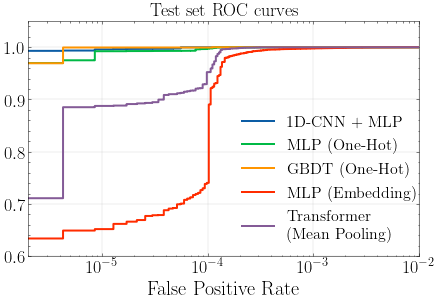

In [7]:
import matplotlib.pyplot as plt
import scienceplots # used by plt.style

from src.plots import set_size, plot_roc_curve

import scienceplots
plt.style.use(['science', 'no-latex'])
plt.rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=set_size())

to_skip = [x for x in y_preds.keys() if 'tabular' in x]
to_keep = {
    # "_tabular_log_reg_onehot": 'LogR (One-Hot)',
    'cnn': '1D-CNN + MLP',
    '_tabular_mlp_onehot': 'MLP (One-Hot)',
    '_tabular_xgb_onehot': 'GBDT (One-Hot)',
    'mlp_seq': 'MLP (Embedding)',
    # 'neurlux': '1D-CNN + LSTM\n+ Attention + MLP',
    # 'cls_transformer': 'Transformer (CLS)',
    'mean_transformer': 'Transformer\n(Mean Pooling)',
    #'_tabular_mlp_minhash': 'MLP (Minhash)',
    # 'lstm': 'LSTM + MLP',
    # 'cnn_lstm': '1D-CNN + LSTM\n+ MLP',
    #'attpool_transformer': 'Transformer\n(Attent. Pooling)',
}
for name in to_keep.keys():
    y_pred_proba = y_preds[name]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    name = to_keep[name]
    plot_roc_curve(fpr, tpr, None, model_name=name, ax=ax, semilogx=True, xlim=[2e-6,1e-2], ylim=[0.6,1.05])

# Create a mapping from labels to handles
handles, labels = ax.get_legend_handles_labels()
label_to_handle = {label: handle for handle, label in zip(handles, labels)}

# labels for ROC curve
ax.set_xlabel("False Positive Rate", fontsize=20)
#ax.set_ylabel("True Positive Rate", fontsize=18)
ax.set_title("Test set ROC curves", fontsize=18)

# ticklbel fontsizes to 18 as well
ax.tick_params(axis='both', which='major', labelsize=18)

# Order the handles based on the order of labels in to_keep.values()
new_handles = [label_to_handle[label] for label in to_keep.values()]
new_labels = list(to_keep.values())
ax.grid(linewidth=0.2)
_ = ax.legend(new_handles, new_labels, ncol=1, fontsize=16, bbox_to_anchor=(1.03, 0), loc='lower right')

# save as pdf in "/img"
fig.savefig(f"img/roc_ablation_models.pdf", bbox_inches='tight', dpi=300)

In [3]:
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

def get_tpr_at_fpr(predicted_logits, true_labels, fprNeeded=1e-4):
    predicted_probs = torch.sigmoid(predicted_logits).cpu().detach().numpy()
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    if all(np.isnan(fpr)):
        return np.nan#, np.nan
    else:
        tpr_at_fpr = tpr[fpr <= fprNeeded][-1]
        return tpr_at_fpr

results_df = pd.DataFrame(columns=['Model', 'TPR at FPR=10^-4', 'F1-Score', 'Precision', 'Recall', 'AUC', 'Accuracy'])


# Loop through each key-value pair in your dictionary, compute the required metrics, and append them to results_df
for model_name, predictions in y_preds.items():
    predicted_probs = torch.sigmoid(torch.tensor(predictions)).cpu().detach().numpy()
    binary_preds = (predicted_probs > 0.5).astype(int)  # Convert probabilities to binary labels with a 0.5 threshold
    
    auc = roc_auc_score(y_test, predicted_probs)
    f1 = f1_score(y_test, binary_preds)
    precision = precision_score(y_test, binary_preds)
    recall = recall_score(y_test, binary_preds)
    accuracy = accuracy_score(y_test, binary_preds)
    tpr_at_fpr_10e4 = get_tpr_at_fpr(torch.tensor(predictions), y_test)
    
    # Append results to dataframe
    new_row = pd.DataFrame({
        'Model': [model_name],
        'TPR at FPR=10^-4': [tpr_at_fpr_10e4],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'AUC': [auc]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Output the results
results_df

,Model,TPR at FPR=10^-4,F1-Score,Precision,Recall,AUC,Accuracy
0,_tabular_mlp_minhash,0.982039,0.985962,0.999899,0.972407,0.999989,0.986155
1,_tabular_rf_minhash,0.790049,0.666658,0.49999,1.0,0.999948,0.49999
2,_tabular_xgb_minhash,0.963397,0.66666,0.499993,1.0,0.999944,0.499995
3,_tabular_log_reg_minhash,0.778231,0.666658,0.49999,1.0,0.999818,0.49999
4,_tabular_mlp_onehot,0.997205,0.997621,0.999923,0.995329,0.999999,0.997626
5,_tabular_rf_onehot,0.952684,0.666658,0.49999,1.0,0.999982,0.49999
6,_tabular_xgb_onehot,0.999426,0.666666,0.499999,1.0,1.0,0.500007
7,_tabular_log_reg_onehot,0.998843,0.666658,0.49999,1.0,1.0,0.49999
8,mlp_seq,0.739207,0.951933,0.999883,0.908372,0.999958,0.954134
9,attpool_transformer,0.910929,0.976357,0.999857,0.953935,0.999875,0.9769


In [4]:
import os
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import scienceplots
plt.style.use(['science', 'no-latex'])
plt.rc('text', usetex=True)

from src.plots import set_size

df_dict = {}
LOGDIR = 'logs_models'

# key_extractor = lambda x: x.split('_')[1:]

for subfolder in os.listdir(LOGDIR):
    subfolder_path = os.path.join(LOGDIR, subfolder)
    csv_file_path = os.path.join(subfolder_path, 'version_0', 'metrics.csv')
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
        encoder = ' '.join(subfolder.split('_')[:-1]).title()
        df_dict[encoder] = df


def extract_metric_values(df_dict, metric_name, operation='last'):
    """
    Extracts specified metric values (either last or max) from nested DataFrames in df_dict.
    
    Parameters:
        df_dict (defaultdict(dict)): Nested dictionary of DataFrames keyed by tokenizer and vocab_size.
        metric_name (str): The name of the metric to extract.
        operation (str): The operation to perform ('last' or 'max').
        
    Returns:
        DataFrame: DataFrame containing the extracted metric values, indexed by vocab_size and columns by tokenizer.
    """
    # Initialize an empty dictionary to temporarily store the extracted values
    extracted_values_temp = {}
    
    # Loop through the nested DataFrames
    for encoder, df in df_dict.items():
        if metric_name in df.columns:
            if operation == 'last':
                # Extract the last value of the specified metric
                last_value = df[metric_name].dropna().iloc[-1]
                extracted_values_temp[encoder] = last_value
                
            elif operation == 'max':
                # Extract the maximum value of the specified metric
                max_value = df[metric_name].dropna().max()
                extracted_values_temp[encoder] = max_value
            else:
                print(f"Invalid operation '{operation}' specified. Skipping {encoder}.")
        else:
            print(f"Metric '{metric_name}' not found in DataFrame for {encoder}. Skipping.")
                
    # Convert the nested dictionary to a DataFrame, using 'metric_name' as value for index
    extracted_values_df = pd.DataFrame.from_dict(extracted_values_temp, orient='index', columns=[metric_name]).transpose()

    # sort index by vocab_size
    extracted_values_df.sort_index(inplace=True)

    return extracted_values_df



In [5]:
metrics = ['val_tpr', 'val_f1', 'val_acc', 'val_auc']
df = pd.DataFrame()
for metric in metrics:
    df1 = extract_metric_values(df_dict, metric, operation='last')
    df = pd.concat([df, df1], axis=0)

tabular_df_dict = {}
for subfolder in os.listdir(LOGDIR):
    subfolder_path = os.path.join(LOGDIR, subfolder)
    csv_file_path = os.path.join(subfolder_path, 'metrics.csv')
    if os.path.exists(csv_file_path):
        ldf = pd.read_csv(csv_file_path)
        encoder = ' '.join(subfolder.split('_')[2:]).title()
        tabular_df_dict[encoder] = ldf

col_map = dict(zip(['tpr', 'f1', 'acc', 'auc'], ['val_tpr', 'val_f1', 'val_acc', 'val_auc']))

# Iterate over each item in the dictionary, map the columns, and concatenate to the initial dataframe
for model_name, ldf in tabular_df_dict.items():
    # Map columns
    ldf = ldf.rename(columns=col_map)
    # Transpose the dataframe so that metrics are in the columns and model names are in the index
    ldf = ldf.T
    # Rename the columns of df to match the model name
    ldf.columns = [model_name]
    # Concatenate along columns axis
    df = pd.concat([df, ldf], axis=1)

df.T

,val_tpr,val_f1,val_acc,val_auc
Attpool Transformer,0.967858,0.982970,0.983254,0.999406
Cls Transformer,0.997018,0.995994,0.996010,0.999996
Cnn,0.999910,0.974444,0.975081,1.000000
Cnn Lstm,0.780494,0.642088,0.736428,0.996596
Lstm,0.972996,0.940016,0.943411,0.999938
Mean Transformer,0.967348,0.994659,0.994687,0.999963
Mlp Seq,0.969886,0.917868,0.924095,0.999945
Neurlux,0.968056,0.900832,0.909776,0.999922
Tabular Mlp Minhash,0.993898,0.986445,0.986625,0.999988
Tabular Mlp Onehot,0.999303,0.993978,0.994014,0.999999


In [6]:
metrics = ['val_tpr', 'val_f1', 'val_acc', 'val_auc']
df = pd.DataFrame()
for metric in metrics:
    df1 = extract_metric_values(df_dict, metric, operation='max')
    df = pd.concat([df, df1], axis=0)

tabular_df_dict = {}
for subfolder in os.listdir(LOGDIR):
    subfolder_path = os.path.join(LOGDIR, subfolder)
    csv_file_path = os.path.join(subfolder_path, 'metrics.csv')
    if os.path.exists(csv_file_path):
        ldf = pd.read_csv(csv_file_path)
        encoder = ' '.join(subfolder.split('_')[2:]).title()
        tabular_df_dict[encoder] = ldf

col_map = dict(zip(['tpr', 'f1', 'acc', 'auc'], ['val_tpr', 'val_f1', 'val_acc', 'val_auc']))

# Iterate over each item in the dictionary, map the columns, and concatenate to the initial dataframe
for model_name, ldf in tabular_df_dict.items():
    # Map columns
    ldf = ldf.rename(columns=col_map)
    # Transpose the dataframe so that metrics are in the columns and model names are in the index
    ldf = ldf.T
    # Rename the columns of df to match the model name
    ldf.columns = [model_name]
    # Concatenate along columns axis
    df = pd.concat([df, ldf], axis=1)

df.T

,val_tpr,val_f1,val_acc,val_auc
Attpool Transformer,0.983769,0.999551,0.999551,0.999963
Cls Transformer,0.997021,0.999889,0.999889,0.999996
Cnn,0.999910,0.999949,0.999949,1.000000
Cnn Lstm,0.916991,0.986644,0.986585,0.997550
Lstm,0.992145,0.967622,0.968636,0.999983
Mean Transformer,0.992789,0.999902,0.999902,0.999988
Mlp Seq,0.980032,0.990541,0.990622,0.999957
Neurlux,0.980555,0.985019,0.984945,0.999957
Tabular Mlp Minhash,0.994517,0.999298,0.999298,0.999989
Tabular Mlp Onehot,0.999554,0.999777,0.999777,0.999999
